In [1]:
import gym
import pybulletgym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ReplayBuffer(object):
    def __init__(self, state_dim, action_dim, max_size=int(1e6)):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0

        self.start_ptr = 0
        self.start_size = 0

        self.state = np.zeros((max_size, state_dim))
        self.action = np.zeros((max_size, action_dim))
        self.next_state = np.zeros((max_size, state_dim))
        self.reward = np.zeros((max_size, 1))
        self.not_done = np.zeros((max_size, 1))

        self.start_state = np.zeros((max_size, state_dim))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def add(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        ind = np.random.randint(self.size, size=batch_size)

        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.FloatTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device)
        )


class Encoder_Decoder(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Encoder_Decoder, self).__init__()

        self.e1 = nn.Linear(state_dim + action_dim, 256)
        self.e2 = nn.Linear(256, 256)

        self.r1 = nn.Linear(256, 1, bias=False)

        self.a1 = nn.Linear(256, 256)
        self.a2 = nn.Linear(256, action_dim)

        self.d1 = nn.Linear(256, 256)
        self.d2 = nn.Linear(256, state_dim)


    def forward(self, state, action):
        l = F.relu(self.e1(torch.cat([state, action], 1)))
        l = F.relu(self.e2(l))
        # l is the latent representation

        # reward prediction
        r = self.r1(l)

        # next_state prediction
        d = F.relu(self.d1(l))
        ns = self.d2(d)

        # action reconstruction
        d = F.relu(self.a1(l))
        a = self.a2(d)

        return ns, r, a, l

    def latent(self, state, action):
        l = F.relu(self.e1(torch.cat([state, action], 1)))
        l = F.relu(self.e2(l))
        return l


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        self.l1 = nn.Linear(state_dim + action_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 256)

    def forward(self, state, action):
        q1 = F.relu(self.l1(torch.cat([state, action], 1)))
        q1 = F.relu(self.l2(q1))
        return self.l3(q1)

# TODO : Try using double-q network
class DoubleCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DoubleCritic, self).__init__()

        self.l1 = nn.Linear(state_dim + action_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 256)

        self.r1 = nn.Linear(state_dim + action_dim, 256)
        self.r2 = nn.Linear(256, 256)
        self.r3 = nn.Linear(256, 256)

    def forward(self, state, action):
        q1 = F.relu(self.l1(torch.cat([state, action], 1)))
        q1 = F.relu(self.l2(q1))

        q2 = F.relu(self.r1(torch.cat([state, action], 1)))
        q2 = F.relu(self.r2(q2))
        return self.l3(q1), self.r3(q2)

    def Q1(self, state, action):
        q1 = F.relu(self.l1(torch.cat([state, action], 1)))
        q1 = F.relu(self.l2(q1))

        return self.l3(q1)
  

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, action_dim)
        
        self.max_action = max_action

    def forward(self, state):
        state = torch.tensor(state).to(device)
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        return self.max_action * torch.tanh(self.l3(a))

class WNet(nn.Module):
    def __init__(self):
        super(WNet, self).__init__()
        self.fc = nn.Linear(256, 1, bias=False)
        
    
    def forward(self, latent):
        return self.fc(latent)


class DSFPG_doubleQ(object):
    def __init__(
        self,
        state_dim,
        action_dim,
        max_action,
        buffer_size=int(1e6),
        discount=0.99,
        tau=0.005,
        delay=5,
        policy_noise=0.2,
        noise_clip=0.5,
        preserve_SR=False,
    ):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.encoder_decoder = Encoder_Decoder(state_dim, action_dim).to(device)
        self.ed_optimizer = torch.optim.Adam(self.encoder_decoder.parameters(), lr=3e-4)

        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=3e-4)

        self.critic = DoubleCritic(state_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)

        # self.W = torch.ones(1, 256, requires_grad=True, device=device)
        self.W = WNet().to(device)
        # self.W_optimizer = torch.optim.Adam([self.W], lr=3e-4)
        self.W_optimizer = torch.optim.Adam(self.W.parameters(), lr=3e-4)

        self.discount = discount
        self.tau = tau

        self.total_it = 0

        self.max_action = max_action

        self.replay = ReplayBuffer(state_dim, action_dim, buffer_size)

        # TD3 improvement
        self.delay = delay
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip

        # perserve SR or not
        self.preserve_SR = preserve_SR

        # psi_loss check
        self.psi_loss = []

    def train_encoder_decoder(self, replay_buffer, batch_size=256):
        # self.replay.add(state, action, next_state, reward, done)
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

        recons_next, recons_reward, recons_action, lat = self.encoder_decoder(state, action)
        ed_loss = F.mse_loss(recons_next, next_state) + 0.1 * F.mse_loss(recons_reward, reward) + F.mse_loss(recons_action, action)

        self.ed_optimizer.zero_grad()
        ed_loss.backward()
        self.ed_optimizer.step()


    def train_SR(self, replay_buffer, batch_size=256):
        # self.replay.add(state, action, next_state, reward, done)
        # print('start training')
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

        with torch.no_grad():
            next_action = self.actor_target(next_state)
            # add randomness to the next action, this should be removed if the result is not ideal
            # next_action = (next_action + torch.randn_like(next_action) * self.max_action * 0.1).clamp(-self.max_action, self.max_action)

            latent = self.encoder_decoder.latent(state, action)
            target_Q = latent + self.discount * not_done * self.critic_target(next_state, next_action)

        current_Q = self.critic(state, action)
        critic_loss = F.mse_loss(current_Q, target_Q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        self.psi_loss.append(critic_loss)

        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


    def train_w(self, replay_buffer, batch_size=256):
        # self.replay.add(state, action, next_state, reward, done)
    
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

        with torch.no_grad():
            latent = self.encoder_decoder.latent(state, action)
        
        reward_estimate = self.W(latent)
        W_loss = F.mse_loss(reward_estimate, reward)

        self.W_optimizer.zero_grad()
        W_loss.backward()
        self.W_optimizer.step()

    def train_actor(self, replay_buffer, batch_size=256):
        # self.replay.add(state, action, next_state, reward, done)
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

        # actor_loss = -(self.critic(state, self.actor(state)) * self.W).mean()
        actor_loss = -self.W(self.critic(state, self.actor(state))).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()


    def soft_update(self):
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


    def train_all(self, replay_buffer, batch_size=256):

        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)
        # note that the phi and the psi are matched, meaning psi is dependent on phi, cannot train psi without train phi
        if not self.perserve_SR: # if we don't have a mature SR yet, learn phi
            '''
            Train Encoder-Decoder
            '''
            recons_next, recons_reward, recons_action, lat = self.encoder_decoder(state, action)
            ed_loss = F.mse_loss(recons_next, next_state) + \
                        0.1 * F.mse_loss(recons_reward, reward) + \
                        F.mse_loss(recons_action, action)

            self.ed_optimizer.zero_grad()
            ed_loss.backward()
            self.ed_optimizer.step()

        '''
        Train SR
        '''
        if not self.perserve_SR: # if we don't have a mature SR yet, learn it
            with torch.no_grad():
                # next_action = self.actor_target(next_state) # try random action instead
                noise = (
                    torch.randn_like(action) * self.policy_noise
                ).clamp(-self.noise_clip, self.noise_clip)

                next_action = (
                    self.actor_target(next_state) + noise
                    # noise / self.policy_noise
                ).clamp(-self.max_action, self.max_action)
                # add randomness to the next action, this should be removed if the result is not ideal
                # next_action = (next_action + torch.randn_like(next_action) * self.max_action * 0.1).clamp(-self.max_action, self.max_action)
                latent = self.encoder_decoder.latent(state, action)
                target_Q1, target_Q2 = self.critic_target(next_state, next_action) # target_Q's are of shape (256, 256)
                target_value1, target_value2 = self.W(target_Q1), self.W(target_Q2)
                
                min_q = torch.where(target_value1 < target_value2, target_Q1, target_Q2) # pick the sf's leading to minimum q-value
                # target_Q = latent + self.discount * not_done * self.critic_target(next_state, next_action)
                target_Q = latent + self.discount * not_done * min_q

            # need to change to double-Q function
            # TODO: Add min-q trick / mean-q update
            current_Q1, current_Q2 = self.critic(state, action)
            
            # compute the critic loss
            critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

        '''
        Train W
        '''
        with torch.no_grad():
            latent = self.encoder_decoder.latent(state, action)
        
        reward_estimate = self.W(latent)
        W_loss = F.mse_loss(reward_estimate, reward)

        self.W_optimizer.zero_grad()
        W_loss.backward()
        self.W_optimizer.step()

        # use delayed update instead
        # self.soft_update()

        # TODO : Add delayed update
        '''
        Train actors
        '''
        # actor_loss = -(self.critic(state, self.actor(state)) * self.W).mean()
        actor_loss = -self.W(self.critic.Q1(state, self.actor(state))).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update()

        # if self.total_it % self.delay == 0:
        #     '''
        #     Train actors
        #     '''
        #     # actor_loss = -(self.critic(state, self.actor(state)) * self.W).mean()
        #     actor_loss = -self.W(self.critic.Q1(state, self.actor(state))).mean()
        #     self.actor_optimizer.zero_grad()
        #     actor_loss.backward()
        #     self.actor_optimizer.step()

        #     self.soft_update()

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()


    def train(self, replay_buffer, batch_size=256):
        self.total_it += 1
        self.train_all(replay_buffer)


        # self.train_actor(state, action, next_state, reward, done)
        # self.train_encoder_decoder(state, action, next_state, reward, done)
        # self.train_SR(state, action, next_state, reward, done)
        # self.train_w(state, action, next_state, reward, done)

In [92]:
from tqdm import trange
import gym
import pybulletgym

def eval_policy(policy, env, seed, eval_episodes=10):
    if isinstance(env, str):
        eval_env = gym.make(env)
    else:
        eval_env = env # a non_proper way 
    eval_env.seed(seed + 100)

    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = eval_env.reset(), False
        while not done:
            action = policy.select_action(np.array(state))
            state, reward, done, _ = eval_env.step(action)
            avg_reward += reward

    avg_reward /= eval_episodes

    print("---------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    print("---------------------------------------")
    return avg_reward

def train_agent(
    agent_func,
    env_name,
    max_steps=int(1e6),
    max_step_before_learning=10000,
    preserve_SR=False,
):
    if isinstance(env_name, str):
        env = gym.make(env_name)
    else:
        env = env_name
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    replay_buffer = ReplayBuffer(state_dim, action_dim)

    policy = agent_func(state_dim, action_dim, max_action) if callable(agent_func) else agent_func # if agent_func is a function, create an agent, otherwise, use the agent
    policy.perserve_SR = preserve_SR

    evaluations = [eval_policy(policy, env_name, 0)] # 0 is the seed

    state, done = env.reset(), False
    episode_reward = 0
    episode_timesteps = 0
    episode_num = 0

    for t in range(int(max_steps)):
        
        episode_timesteps += 1

        # Select action randomly or according to policy
        if t < max_step_before_learning:
            action = env.action_space.sample()
        else:
            action = (
                policy.select_action(np.array(state))
                + np.random.normal(0, max_action * 0.2, size=action_dim)
            ).clip(-max_action, max_action)

        # Perform action
        next_state, reward, done, _ = env.step(action) 
        try:
            done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0
        except:
            done_bool = float(done) if episode_timesteps < 1000 else 0

        # Store data in replay buffer
        replay_buffer.add(state, action, next_state, reward, done_bool)

        state = next_state
        episode_reward += reward

        # Train agent after collecting sufficient data
        if t >= max_step_before_learning:
            policy.train(replay_buffer, 128)

        if done: 
            # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
            print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
            # Reset environment
            state, done = env.reset(), False
            episode_reward = 0
            episode_timesteps = 0
            episode_num += 1 

        # Evaluate episode
        if (t + 1) % 1000 == 0:
            evaluations.append(eval_policy(policy, env_name, 0))
    
    return evaluations, policy


# Hopper Performance 

In [ ]:
evaluations, policy = train_agent(DSFPG_doubleQ, 'Hopper-v2')

/home/yiranwang/anaconda3/envs/DPC/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


---------------------------------------
Evaluation over 10 episodes: 37.286
---------------------------------------
Total T: 12 Episode Num: 1 Episode T: 12 Reward: 9.643
Total T: 34 Episode Num: 2 Episode T: 22 Reward: 15.656
Total T: 70 Episode Num: 3 Episode T: 36 Reward: 18.608
Total T: 105 Episode Num: 4 Episode T: 35 Reward: 49.606
Total T: 134 Episode Num: 5 Episode T: 29 Reward: 23.323
Total T: 148 Episode Num: 6 Episode T: 14 Reward: 12.287
Total T: 172 Episode Num: 7 Episode T: 24 Reward: 13.227
Total T: 183 Episode Num: 8 Episode T: 11 Reward: 10.326
Total T: 205 Episode Num: 9 Episode T: 22 Reward: 19.624
Total T: 219 Episode Num: 10 Episode T: 14 Reward: 9.337
Total T: 229 Episode Num: 11 Episode T: 10 Reward: 6.725
Total T: 251 Episode Num: 12 Episode T: 22 Reward: 9.164
Total T: 262 Episode Num: 13 Episode T: 11 Reward: 6.467
Total T: 272 Episode Num: 14 Episode T: 10 Reward: 7.476
Total T: 292 Episode Num: 15 Episode T: 20 Reward: 18.935
Total T: 305 Episode Num: 16 Epi

# HalfCheetah Performance

In [ ]:
evaluations_hc, policy_hc = train_agent(DSFPG_doubleQ, 'HalfCheetah-v2')

# Walker2D Performance

In [ ]:
evaluations_walker, policy_walker = train_agent(DSFPG_doubleQ, 'Walker2d-v2')

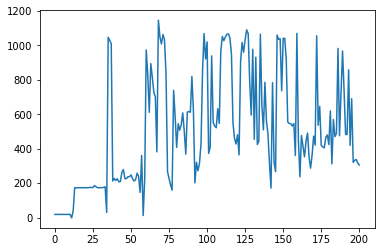

In [10]:
import matplotlib.pyplot as plt
plt.plot(range(201), evaluations)
plt.show()

In [14]:
from numpy import convolve

def plot_rewards(rewards, plot_seperate=True , clip=int(1e6), title='unnamed'):
    smooth = 5000
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
    plt.figure(figsize=(16,6), dpi=200)
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip-smooth+1))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(loc='lower right'), plt.show()

In [ ]:
plot_rewards({'DSFPG-Hopper' : [range(201), evaluations]}, plot_seperate=False)

In [78]:
import numpy as np
from gym import utils
from gym.envs.mujoco import mujoco_env

class HopperNegEnv(mujoco_env.MujocoEnv, utils.EzPickle):
    def __init__(self):
        mujoco_env.MujocoEnv.__init__(self, 'hopper.xml', 4)
        utils.EzPickle.__init__(self)

    def step(self, a):
        posbefore = self.sim.data.qpos[0]
        self.do_simulation(a, self.frame_skip)
        posafter, height, ang = self.sim.data.qpos[0:3]
        alive_bonus = 1.0
        reward = -(posafter - posbefore) / self.dt
        reward += alive_bonus
        reward -= 1e-3 * np.square(a).sum()
        s = self.state_vector()
        done = not (np.isfinite(s).all() and (np.abs(s[2:]) < 100).all() and
                    (height > .7) and (abs(ang) < .2))
        ob = self._get_obs()
        return ob, reward, done, {}

    def _get_obs(self):
        return np.concatenate([
            self.sim.data.qpos.flat[1:],
            np.clip(self.sim.data.qvel.flat, -10, 10)
        ])

    def reset_model(self):
        qpos = self.init_qpos + self.np_random.uniform(low=-.005, high=.005, size=self.model.nq)
        qvel = self.init_qvel + self.np_random.uniform(low=-.005, high=.005, size=self.model.nv)
        self.set_state(qpos, qvel)
        return self._get_obs()

    def viewer_setup(self):
        self.viewer.cam.trackbodyid = 2
        self.viewer.cam.distance = self.model.stat.extent * 0.75
        self.viewer.cam.lookat[2] = 1.15
        self.viewer.cam.elevation = -20


In [79]:
evaluation_neg, policy_neg = train_agent(policy, HopperNegEnv(), preserve_SR=True)

/home/yiranwang/anaconda3/envs/DPC/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


---------------------------------------
Evaluation over 10 episodes: -51.492
---------------------------------------
Total T: 27 Episode Num: 1 Episode T: 27 Reward: 25.741
Total T: 39 Episode Num: 2 Episode T: 12 Reward: 13.988
Total T: 50 Episode Num: 3 Episode T: 11 Reward: 13.815
Total T: 82 Episode Num: 4 Episode T: 32 Reward: 25.346
Total T: 100 Episode Num: 5 Episode T: 18 Reward: 27.673
Total T: 160 Episode Num: 6 Episode T: 60 Reward: 63.908
Total T: 194 Episode Num: 7 Episode T: 34 Reward: 42.953
Total T: 217 Episode Num: 8 Episode T: 23 Reward: 28.697
Total T: 241 Episode Num: 9 Episode T: 24 Reward: 22.073
Total T: 260 Episode Num: 10 Episode T: 19 Reward: 26.401
Total T: 281 Episode Num: 11 Episode T: 21 Reward: 32.818
Total T: 304 Episode Num: 12 Episode T: 23 Reward: 27.173
Total T: 318 Episode Num: 13 Episode T: 14 Reward: 16.702
Total T: 340 Episode Num: 14 Episode T: 22 Reward: 28.561
Total T: 351 Episode Num: 15 Episode T: 11 Reward: 15.684
Total T: 378 Episode Num: 

KeyboardInterrupt: 

In [85]:
class Actor(nn.Module):
	def __init__(self, state_dim, action_dim, max_action):
		super(Actor, self).__init__()

		self.l1 = nn.Linear(state_dim, 256)
		self.l2 = nn.Linear(256, 256)
		self.l3 = nn.Linear(256, action_dim)
		
		self.max_action = max_action
		

	def forward(self, state):
		a = F.relu(self.l1(state))
		a = F.relu(self.l2(a))
		return self.max_action * torch.tanh(self.l3(a))


class Critic(nn.Module):
	def __init__(self, state_dim, action_dim):
		super(Critic, self).__init__()

		# Q1 architecture
		self.l1 = nn.Linear(state_dim + action_dim, 256)
		self.l2 = nn.Linear(256, 256)
		self.l3 = nn.Linear(256, 1)

		# Q2 architecture
		self.l4 = nn.Linear(state_dim + action_dim, 256)
		self.l5 = nn.Linear(256, 256)
		self.l6 = nn.Linear(256, 1)


	def forward(self, state, action):
		sa = torch.cat([state, action], 1)

		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)

		q2 = F.relu(self.l4(sa))
		q2 = F.relu(self.l5(q2))
		q2 = self.l6(q2)
		return q1, q2


	def Q1(self, state, action):
		sa = torch.cat([state, action], 1)

		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)
		return q1


class TD3(object):
	def __init__(
		self,
		state_dim,
		action_dim,
		max_action,
		discount=0.99,
		tau=0.005,
		policy_noise=0.2,
		noise_clip=0.5,
		policy_freq=2
	):

        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=3e-4)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)

        self.max_action = max_action
        self.discount = discount
        self.tau = tau
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_freq = policy_freq

        self.total_it = 0
        self.preserve_SR = False


    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()


    def train(self, replay_buffer, batch_size=256):
        self.total_it += 1

        # Sample replay buffer 
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

        with torch.no_grad():
            # Select action according to policy and add clipped noise
            noise = (
                torch.randn_like(action) * self.policy_noise
            ).clamp(-self.noise_clip, self.noise_clip)

            next_action = (
                self.actor_target(next_state) + noise
            ).clamp(-self.max_action, self.max_action)

            # Compute the target Q value
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + not_done * self.discount * target_Q

        # Get current Q estimates
        current_Q1, current_Q2 = self.critic(state, action)

        # Compute critic loss
        critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Delayed policy updates
        if self.total_it % self.policy_freq == 0:

            # Compute actor losse
            actor_loss = -self.critic.Q1(state, self.actor(state)).mean()

            # Optimize the actor 
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Update the frozen target models
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


    def save(self, filename):
        torch.save(self.critic.state_dict(), filename + "_critic")
        torch.save(self.critic_optimizer.state_dict(), filename + "_critic_optimizer")

        torch.save(self.actor.state_dict(), filename + "_actor")
        torch.save(self.actor_optimizer.state_dict(), filename + "_actor_optimizer")


    def load(self, filename):
        self.critic.load_state_dict(torch.load(filename + "_critic"))
        self.critic_optimizer.load_state_dict(torch.load(filename + "_critic_optimizer"))
        self.critic_target = copy.deepcopy(self.critic)

        self.actor.load_state_dict(torch.load(filename + "_actor"))
        self.actor_optimizer.load_state_dict(torch.load(filename + "_actor_optimizer"))
        self.actor_target = copy.deepcopy(self.actor)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 87)

__main__.TD3

In [88]:
evaluation_neg, TD3_Neg = train_agent(TD3, HopperNegEnv(), preserve_SR=True)

---------------------------------------
Evaluation over 10 episodes: 23.260
---------------------------------------
Total T: 9 Episode Num: 1 Episode T: 9 Reward: 12.728
Total T: 39 Episode Num: 2 Episode T: 30 Reward: 48.241
Total T: 49 Episode Num: 3 Episode T: 10 Reward: 11.596
Total T: 72 Episode Num: 4 Episode T: 23 Reward: 19.347
Total T: 94 Episode Num: 5 Episode T: 22 Reward: 32.122
Total T: 108 Episode Num: 6 Episode T: 14 Reward: 17.612
Total T: 134 Episode Num: 7 Episode T: 26 Reward: 29.772
Total T: 159 Episode Num: 8 Episode T: 25 Reward: 38.622
Total T: 170 Episode Num: 9 Episode T: 11 Reward: 15.631
Total T: 203 Episode Num: 10 Episode T: 33 Reward: 38.053
Total T: 236 Episode Num: 11 Episode T: 33 Reward: 32.759
Total T: 261 Episode Num: 12 Episode T: 25 Reward: 32.943
Total T: 277 Episode Num: 13 Episode T: 16 Reward: 21.407
Total T: 288 Episode Num: 14 Episode T: 11 Reward: 13.008
Total T: 303 Episode Num: 15 Episode T: 15 Reward: 13.533
Total T: 324 Episode Num: 16 E

KeyboardInterrupt: 